In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from jax import config
config.update('jax_enable_x64', True)
import matplotlib.pyplot as plt
import corner
import pandas as pd

In [2]:
# 1PL1PS magnification
def paczynski(t, tE, t0, u0):
    u2 = u0**2 + (t - t0)**2 / tE**2
    u = jnp.sqrt(u2)
    A = (u2 + 2) / (u * jnp.sqrt(u2 + 4))
    return A

def flux_model(time, p):
    Fb, Fs, tE, t0, u0 = p
    return Fb + Fs * paczynski(time, tE, t0, u0)

## true model

In [3]:
time = jnp.linspace(-100, 100, 1000)

In [4]:
tE, t0, u0 = 10., 0, 0.3
Fs, Fb = 1000, 10
params_true = [Fb, Fs, tE, t0, u0]
keys = ["Fb", "Fs", "tE", "t0", "u0"]

In [5]:
flux_true = flux_model(time, params_true)
flux_err = np.sqrt(flux_true)

## add white noise

In [6]:
np.random.seed(123)
flux_white = flux_true + np.random.randn(len(flux_true)) * flux_err

## add correlated noise
ノイズを多次元正規分布からサンプル

In [7]:
# RBF kernel
def cov_rbf(x, tau, alpha, sigma):
    dx = x[:,None] - x[None, :]
    return alpha**2 * jnp.exp(-0.5 * (dx / tau)**2) + jnp.diag(sigma**2)

In [8]:
tau = 10.
alpha = 30.

In [9]:
mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov_rbf(time, tau, alpha, flux_err))

In [10]:
flux_corr = flux_true + mv.sample(random.PRNGKey(0))

## comparison

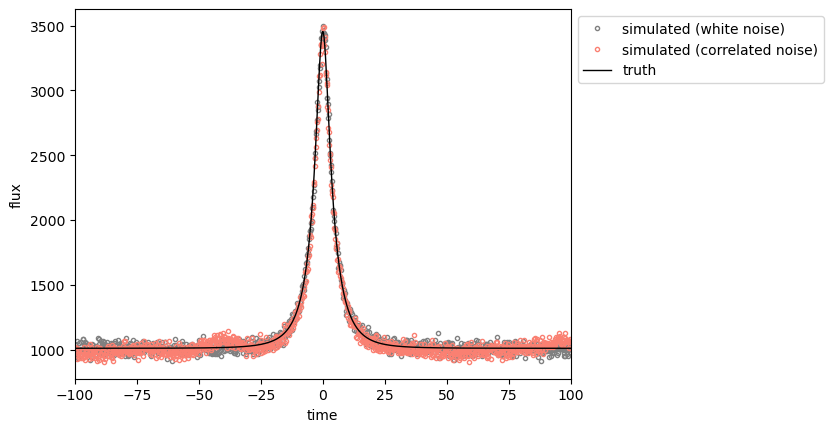

In [11]:
plt.ylabel("flux")
plt.xlabel("time")
plt.xlim(time[0], time[-1])
plt.plot(time, flux_white, '.', mfc='none', color='gray', label='simulated (white noise)')
plt.plot(time, flux_corr, '.', mfc='none', color='salmon', label='simulated (correlated noise)')
plt.plot(time, flux_true, '-', label='truth', color='k', lw=1)
plt.legend(loc='best', bbox_to_anchor=(1,1));

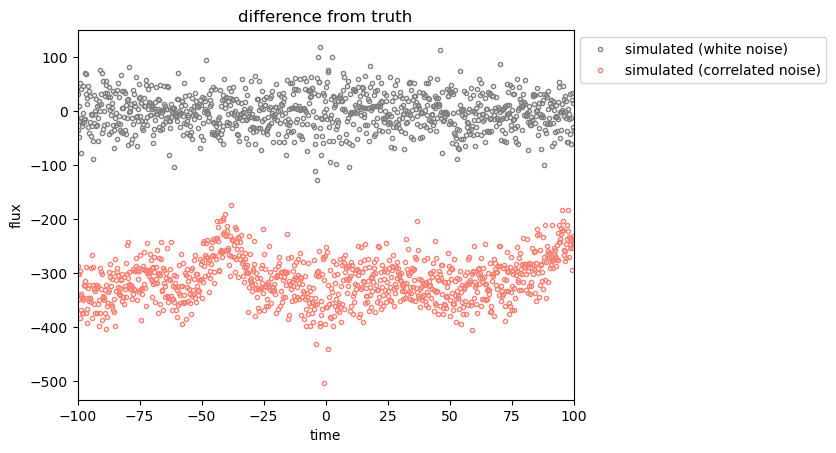

In [12]:
plt.title("difference from truth")
plt.ylabel("flux")
plt.xlabel("time")
plt.xlim(time[0], time[-1])
plt.plot(time, flux_white-flux_true, '.', mfc='none', color='gray', label='simulated (white noise)')
plt.plot(time, flux_corr-flux_true-300, '.', mfc='none', color='salmon', 
         label='simulated (correlated noise)')
plt.legend(loc='best', bbox_to_anchor=(1,1));

## MCMC assuming white noise

In [13]:
def model_white(x, yobs):
    Fs = numpyro.sample("Fs", dist.Uniform(0, 5000))
    Fb = numpyro.sample("Fb", dist.Uniform(-500, 2000))

    lntE = numpyro.sample("lntE", dist.Uniform(jnp.log(1), jnp.log(100)))
    tE = numpyro.deterministic("tE", jnp.exp(lntE))
    
    t0 = numpyro.sample("t0", dist.Uniform(-50, 50))
    u0 = numpyro.sample("u0", dist.Uniform(0, 5))
    
    ymodel = numpyro.deterministic("ymodel", flux_model(x, [Fb, Fs, tE, t0, u0]))
    numpyro.sample("obs", dist.Normal(loc=ymodel, scale=jnp.sqrt(yobs)), obs=yobs)

In [14]:
kernel = numpyro.infer.NUTS(model_white)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=5000)

In [15]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, time, flux_corr)

sample: 100%|█████████████████████████████| 6000/6000 [00:10<00:00, 592.56it/s, 47 steps of size 9.81e-03. acc. prob=0.94]


In [16]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Fb    -22.67     69.31    -20.43   -128.48     98.26    420.93      1.01
        Fs   1024.25     69.73   1021.95    902.43   1131.22    420.80      1.01
      lntE      2.27      0.03      2.27      2.21      2.33    421.32      1.01
        t0      0.01      0.02      0.01     -0.02      0.05   2362.20      1.00
        u0      0.31      0.02      0.31      0.28      0.33    420.13      1.01

Number of divergences: 0


In [17]:
samples = mcmc.get_samples()

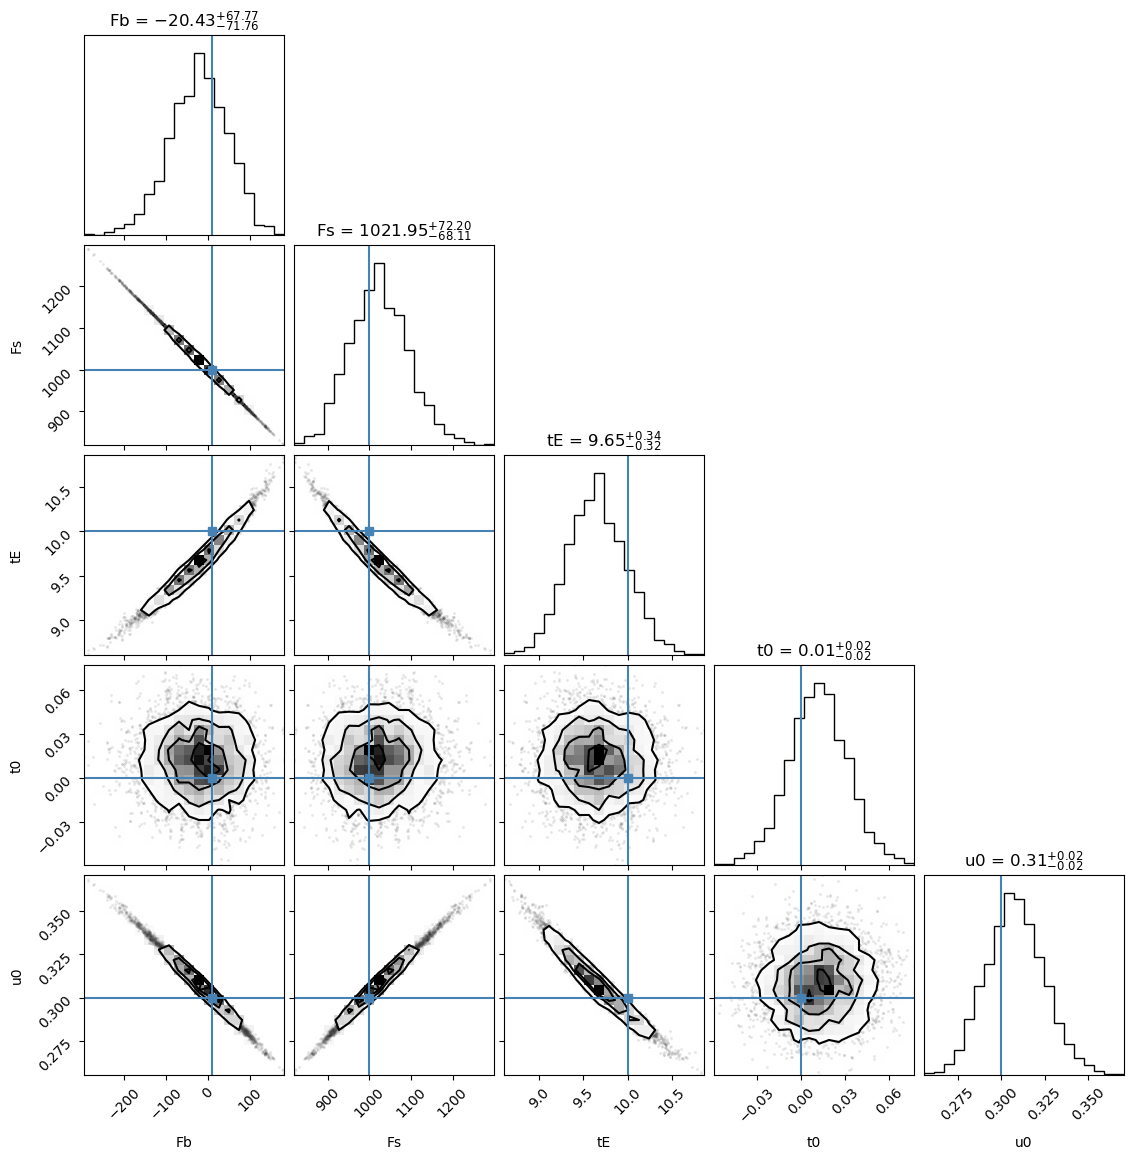

In [18]:
fig = corner.corner(np.array([samples[key] for key in keys]).T, 
                    labels=keys, show_titles=True, truths=params_true)

青が真の値。この場合そんなに悪くないが、tEとFb, Fs, u0の2次元分布でみると真の値からずれている。

## MCMC w/ GP noise model

In [19]:
# のでここではcelerite2でやる。tinygp https://tinygp.readthedocs.io/en/stable/ でもいいはず
import celerite2
from celerite2.jax import terms as jax_terms
def model_gp(x, yobs):
    Fs = numpyro.sample("Fs", dist.Uniform(0, 5000))
    Fb = numpyro.sample("Fb", dist.Uniform(-500, 2000))

    lntE = numpyro.sample("lntE", dist.Uniform(jnp.log(1), jnp.log(100)))
    tE = numpyro.deterministic("tE", jnp.exp(lntE))
    
    t0 = numpyro.sample("t0", dist.Uniform(-50, 50))
    u0 = numpyro.sample("u0", dist.Uniform(0, 5))
    
    ymodel = numpyro.deterministic("ymodel", flux_model(x, [Fb, Fs, tE, t0, u0]))
    
    lna = numpyro.sample("lna", dist.Uniform(0, 4))
    lnrho = numpyro.sample("lnrho", dist.Uniform(0, 4))
    kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnrho))
    gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
    gp.compute(x, diag=yobs)
    numpyro.sample("obs", gp.numpyro_dist(), obs=yobs-ymodel)

In [20]:
kernel = numpyro.infer.NUTS(model_gp)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=5000)

In [21]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, time, flux_corr)

sample: 100%|█████████████████████████████| 6000/6000 [00:48<00:00, 123.56it/s, 15 steps of size 3.54e-02. acc. prob=0.94]


In [22]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Fb    -79.65    178.88    -71.55   -382.62    207.96    696.48      1.00
        Fs   1086.73    181.92   1079.47    792.55   1394.27    683.31      1.00
       lna      3.52      0.24      3.52      3.15      3.92   1056.70      1.00
     lnrho      2.81      0.26      2.82      2.38      3.23   1145.94      1.00
      lntE      2.23      0.11      2.23      2.05      2.40    737.88      1.00
        t0     -0.01      0.03     -0.01     -0.06      0.03   4724.54      1.00
        u0      0.32      0.04      0.32      0.25      0.40    694.33      1.00

Number of divergences: 0


In [23]:
samples = mcmc.get_samples()

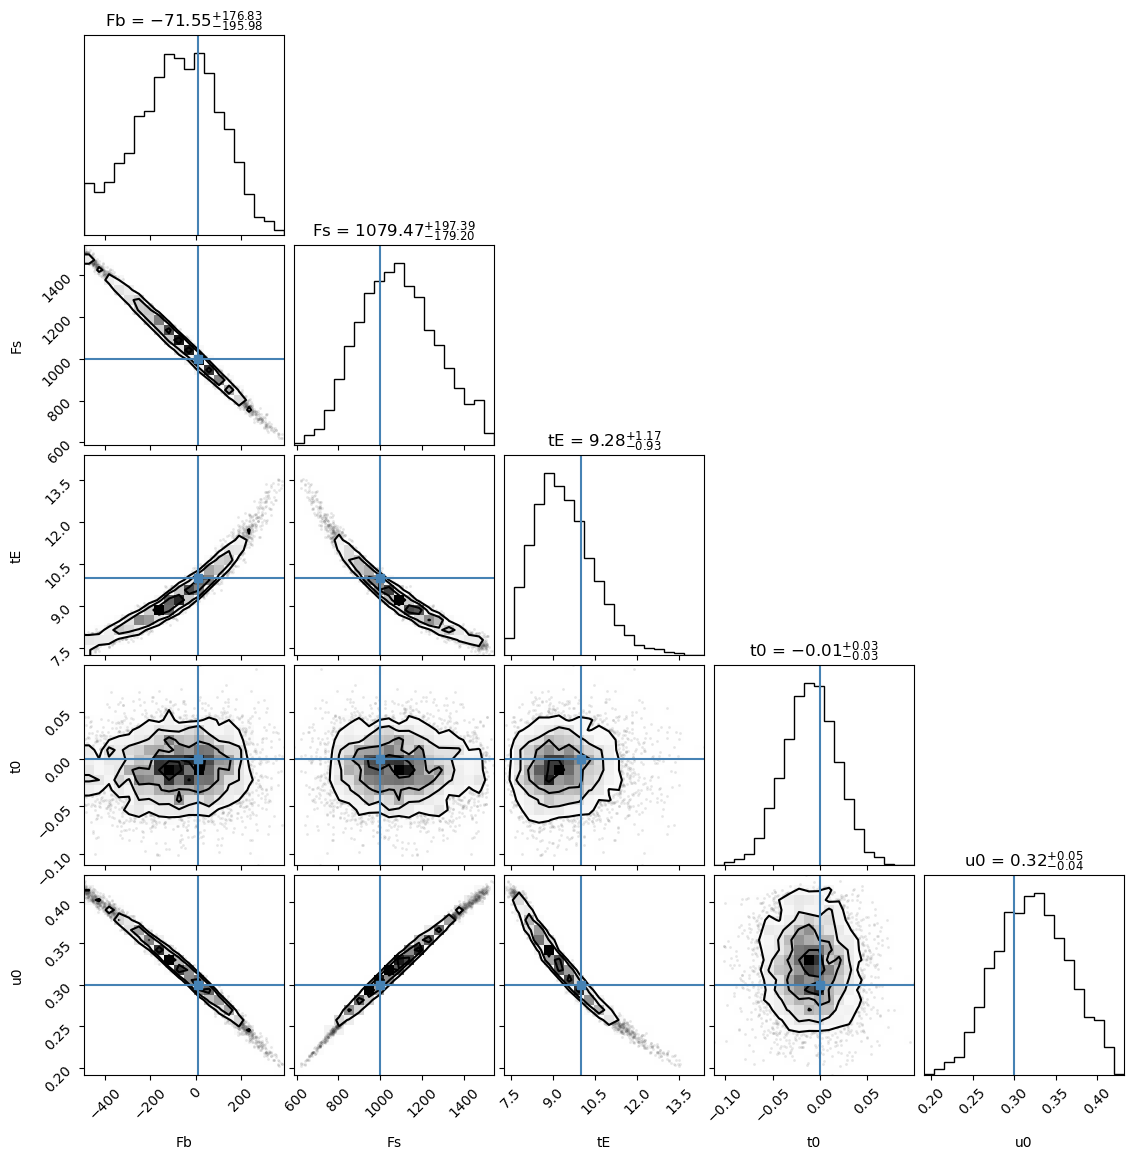

In [24]:
fig = corner.corner(np.array([samples[key] for key in keys]).T, 
                    labels=keys, show_titles=True, truths=params_true)

### plot models

In [25]:
def compute_prediction(samples, idx):
    lna, lnr, ymodel = samples['lna'][idx], samples['lnrho'][idx], samples['ymodel'][idx]
    kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnr))
    gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
    gp.compute(time, diag=flux_corr)
    f_pred = gp.predict(flux_corr-ymodel)
    return f_pred, ymodel

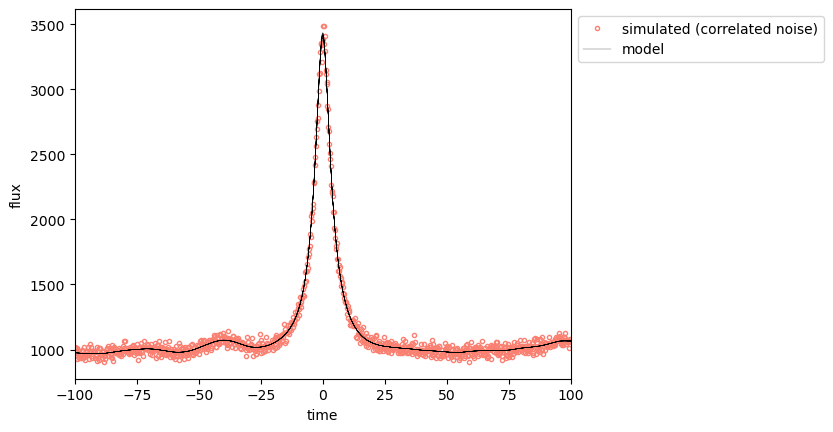

In [26]:
plt.ylabel("flux")
plt.xlabel("time")
plt.xlim(time[0], time[-1])
plt.plot(time, flux_corr, '.', mfc='none', color='salmon', label='simulated (correlated noise)')
label = 'model'
for idx in np.random.randint(0, len(samples['tE']), 20):
    gppred, ymodel = compute_prediction(samples, idx)
    plt.plot(time, gppred+ymodel, '-', color='k', lw=0.2, label=label)
    label = ''
plt.legend(loc='best', bbox_to_anchor=(1,1));

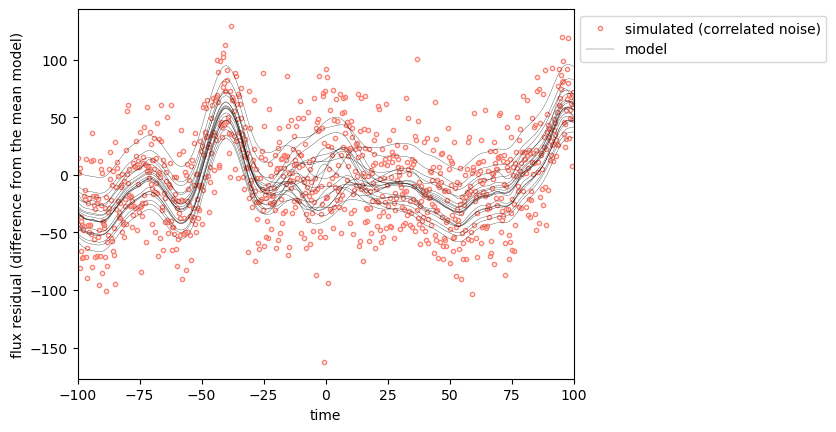

In [27]:
plt.ylabel("flux residual (difference from the mean model)")
plt.xlabel("time")
plt.xlim(time[0], time[-1])
plt.plot(time, flux_corr-np.mean(samples['ymodel'], axis=0), '.', mfc='none', color='salmon', label='simulated (correlated noise)')
label = 'model'
for idx in np.random.randint(0, len(samples['tE']), 20):
    gppred, ymodel = compute_prediction(samples, idx)
    plt.plot(time, gppred, '-', color='k', lw=0.2, label=label)
    label = ''
plt.legend(loc='best', bbox_to_anchor=(1,1));